# 23-1. 들어가며

이번 시간에는 Pose estimation 모델을 학습시키기 위해 활용할 수 있는 데이터셋(MPII Human Pose Dataset)에 대해 알아보고, pre-trained 된 가중치를 활용하여 테스트 이미지로 직접 모델의 성능을 확인해 볼 예정입니다.

### MPII 데이터셋 다운로드하기
---
오늘은 MPII Human Pose Dataset을 사용해서 Human Pose Estimation task를 위한 모델을 훈련시켜 보겠습니다.

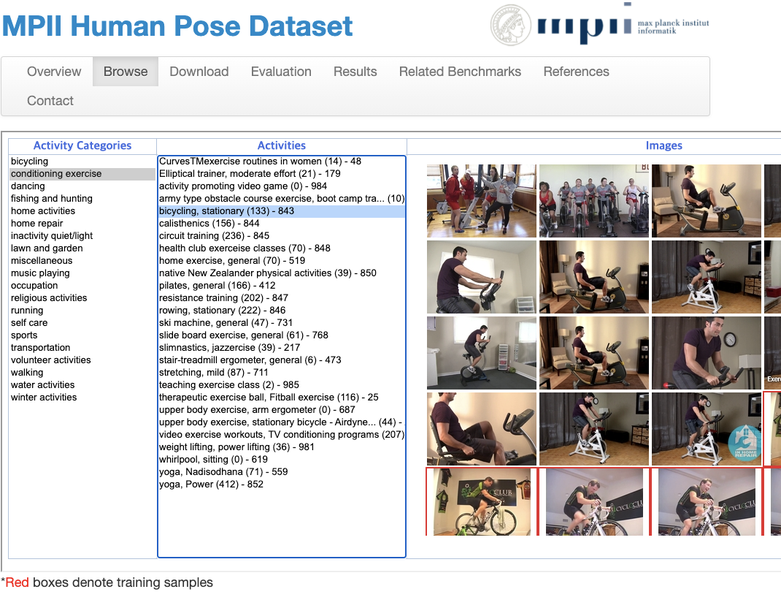  
http://human-pose.mpi-inf.mpg.de/#download  

미리 준비해 둔 데이터를 연결하고 압축을 해제해 주세요.
```bash
$ mkdir -p ~/aiffel/mpii
$ ln -s ~/data/* ~/aiffel/mpii
$ cd ~/aiffel/mpii
$ tar -xvf mpii_human_pose_v1.tar.gz -C . 
$ unzip mpii_human_pose_v1_u12_2.zip
```

mpii_human_pose_v1_u12_2.zip 을 풀어보면 mpii_human_pose_v1_u12_1.mat 파일이 나와서 열어보기 불편한데요. 파이썬에서 읽기 쉽도록 json 파일로 변환해 두었습니다.

```bash
$ cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json
```

mpii.zip
마지막으로, 오늘의 실습 코드를 프로젝트로 구성한 파일을 압축 해제합니다.

```bash
$ cd ~/aiffel/mpii && unzip mpii.zip
```

이번 노드에서는 이 프로젝트 파일을 LMS환경에 맞게 편집하여 진행합니다. .py 파일 원본을 확인하면 학습에 도움이 되실거예요.

### 학습 목표
---
1. Pose estimation 모델을 학습시키기 위한 데이터셋을 확보할 수 있습니다.
2. 학습 데이터를 빠르게 읽게 하기 위한 TFRecord 형태를 이해하고 활용할 수 있습니다.
3. TFRecord 형태로 저장된 데이터를 모델 학습에 맞게 전처리 시킬 수 있습니다.
4. Stacked Hourglass Network를 구현할 수 있습니다.

### 학습 내용
---
2. 데이터 전처리하기
    - json 파일의 구성을 파악하고, 파싱하는 함수를 구현해봅시다.
3. TFRecord 파일 만들기
    - 학습 데이터를 더 빠르게 읽게 하기 위한 TFRecord 형태로 표현하는 방법을 배워봅니다.
4. Ray
    - 병렬 처리를 위한 라이브러리인 Ray에 대해 공부해보아요.
5. data label로 만들기
    - TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 전처리하는 방법을 학습해봅시다.
6. 모델을 학습해보자
    - Hourglass 모델의 구조를 복습하고, 모델을 직접 구현해봅니다.
7. 학습 엔진 만들기
    - GPU가 여러 개이고 데이터를 병렬로 학습시키는 방법에 대해 공부해보아요.
8. 둠칫둠칫 댄스타임
    - 학습이 끝난 모델의 inference 파이프라인을 구축해봅시다.

# 23-2. 데이터 전처리하기

앞으로 사용할 라이브러리를 불러옵니다. 고정해서 사용할 변수도 만들어 두죠.

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


#### json 파싱하기

이전 스텝에서 train.json과 validation.json 파일이 소개된 것을 기억하시나요? 이 파일들은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있어서 Pose Estimation을 위한 label로 삼을 수 있습니다.

우선 json이 어떻게 구성되어 있는지 파악해 보기 위해 json 파일을 열어 샘플로 annotation 정보를 1개만 출력해 봅시다. json.dumps()를 활용해서 좀 더 명확하게 하면 더욱 좋습니다.






In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


joints 가 우리가 label 로 사용할 keypoint 의 label 입니다. 이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문에 joints_vis 를 이용해서 실제로 사용할 수 있는 keypoint 인지 나타냅니다. MPII 의 경우 1 (visible) / 0(non) 으로만 나누어지기 때문에 조금 더 쉽게 사용할 수 있습니다. coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label 화 되어 있습니다.

joints 순서는 아래와 같은 순서로 배치되어 저장해 뒀습니다.

    0 - 오른쪽 발목
    1 - 오른쪽 무릎
    2 - 오른쪽 엉덩이
    3 - 왼쪽 엉덩이
    4 - 왼쪽 무릎
    5 - 왼쪽 발목
    6 - 골반
    7 - 가슴(흉부)
    8 - 목
    9 - 머리 위
    10 - 오른쪽 손목
    11 - 오른쪽 팔꿈치
    12 - 오른쪽 어깨
    13 - 왼쪽 어깨
    14 - 왼쪽 팔꿈치
    15 - 왼쪽 손목  
    
scale과 center는 사람 몸의 크기와 중심점 입니다.scale은 200을 곱해야 온전한 크기가 됩니다. 추후에 전처리 과정에서 200을 곱해서 사용할 예정이에요.

이제 json annotation 을 파싱하는 함수를 만들어 보겠습니다.

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


한 번 parse_one_annotation()함수를 테스트 해봅시다.

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


이제 우리가 원하는 정보만 뽑아낼 수 있게 되었네요. 다음으로 넘어가보죠.

#### Q. MPII 데이터셋에서 json 파일에서 'scale' 정보가 의미하는 바는 무엇인가요?
MPII 데이터셋에서 'scale'은 사람의 크기 비율을 나타내는데, 관절의 위치 및 사람의 신체 부분 크기를 상대적으로 표현하는 데 사용됩니다.
일반적으로 관절의 좌표는 이미지의 크기에 따라 상대적으로 바뀌는 값이기 때문에 이를 보정하기 위해 scale 값을 제공하는 것이며, 이를 통해서 다른 크기의 이미지에서도 신체 부위의 위치를 일관성 있게 분석할 수 있습니다.

# 23-3. TFRecord 파일 만들기

###  TFRecord 파일 만들기

이전까지는 tf.keras 의 ImageDataGenerator 를 이용해서 주로 학습 데이터를 읽었습니다. 하지만 실제 프로젝트에서는 튜토리얼 데이터셋보다 훨씬 큰 크기의 데이터를 다뤄야 합니다.

학습을 많이 해볼수록 학습 속도에 관심을 가지게 되는데요. tensorflow 튜토리얼 문서에는 다음과 같은 표현으로 나타나 있습니다.

> unless you are using tf.data and reading data is still the bottleneck to training.

일반적으로 학습 과정에서 gpu 의 연산 속도보다 HDD I/O 가 느리기 때문에 병목 현상이 발생하고 대단위 프로젝트 실험에서 효율성이 떨어지는 것을 관찰할 수 있습니다. (답답해요..)

따라서 "학습 데이터를 어떻게 빠르게 읽는가?" 에 대한 고민을 반드시 수행하셔야 더 많은 실험을 할 수 있습니다.

다음 링크를 보고 퀴즈를 풀어 봅시다.

- tf.data API로 성능 향상하기 https://www.tensorflow.org/guide/data_performance?hl=ko

#### Q. 학습 속도를 향상시키기 위해서 데이터 관점에서 고려해야하는 단계는 어떤 단계인가요? 속도 향상을 위한 처리 방법을 위 링크에서 찾아대답해 봅시다.
입력 파이프라인
데이터 전처리 병렬화, Prefetching, Caching, Shuffling  

data read(또는 prefetch) 또는 데이터 변환 단계. gpu 학습과 병렬적으로 수행되도록 prefetch를 적용해야 함. 수행방법은 tf.data의 map 함수를 이용하고 cache 에 저장해두는 방법을 사용해야함.

내용이 꽤 어렵습니다만 tf 에서는 위 변환을 자동화해주는 도구를 제공합니다. 데이터셋을 TFRecord 형태로 표현하는 것인데요. TFRecord 는 binary record sequence 를 저장하기 위한 형식입니다.

내부적으로 protocol buffer 라는 것을 이용합니다.

https://developers.google.com/protocol-buffers/?hl=ko https://protobuf.dev/  

protocol buffer 는 크로스 플랫폼에서 사용할 수 있는 직렬화 데이터 라이브러리라고 생각하시면 됩니다.

데이터를 직렬화 한다는 것은 의미가 있는 정보만 추출해 나열하는 것을 뜻합니다. 예를 들어 "서울 강동구에 사는 32살 고길동"님을 나타내기 위해 "서울강동32고길동"과 같이 쓴다면 데이터만 담을 수 있겠죠? 다만 데이터 형식을 고정해야 하기 때문에 첫 두 글자는 시를 뜻하고, 다음 두 글자는 구를 뜻하고 다음 두 자리 숫자가 오고 이름은 세 글자여야 하는 제한이 생깁니다. 100살이 넘는 사람이나 이름이 세 글자가 아닌 사람을 담을 수 없어요. 그래서 매우 정형화된 데이터는 직렬화 하면 데이터 크기와 처리 속도 측면에서 유리하지만 사용하는데 제한이 있다고 기억하면 좋습니다. 어떤 데이터에서 어떤 방법으로 직렬화를 수행할지에 따라 발생되는 제한이 달라질 수도 있고요.

이제 구현을 시작하겠습니다. 하나하나 천천히 가보죠. 앞서 추출한 annotation을 TFRecord로 변환하는 함수를 만들게요. TFRecord 는 tf.train.Example들의 합으로 이루어지므로 하나의 annotation을 하나의 tf.train.Example로 만들어 주는 함수부터 작성합니다.

In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


하나의 annotation이 tf.train.Example이 되었다면 이제 여러 annotation에 대해 작업할 수 있도록 함수를 만들어야 합니다.

그런데 여기서 하나의 TFRecord를 만들지 않고 여러 TFRecord를 만들어 볼 거예요. 우선 얼마나 많은 TFRecord를 만들지 결정할 함수를 만들게요.

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


이 함수는 전체 데이터를 몇 개의 그룹으로 나눌지 결정해 줍니다. 전체 데이터 l을 n그룹으로 나눕니다. 결과적으로 n개의 TFRecord 파일을 만들겠다는 이야기입니다.

여기서 좀 더 전문적으로는 n개로 shard 했다고 말합니다. 기업 단위의 데이터는 매우 크고 여러 장비에 나누어져 있기 때문에 sharding은 자주 이루어 집니다. 하나의 큰 데이터를 여러 개의 파일로 쪼개고 여러 컴퓨터에 나누어 담는 것이라고 여기면 됩니다. 이렇게 하면 데이터 저장에도 용이하고 병렬 처리에 하는데 이점이 있습니다.

이 때, 이 데이터는 원래 하나의 큰 데이터였기 때문에 저장 후 어떻게 사용할 것인가에 따라서 sharding 전략이 달라지는데요. 그 내용을 다루기에는 너무 방대하니 여기서는 간단히만 다룹니다. 모델을 학습하는데 각 파일의 크기와 개수만 고려해보면, 너무 작은 파일로 많이 나누는 것도, 너무 큰 파일로 적게 나누는 것도 좋지 않습니다. 너무 작은 파일로 많이 나누면 학습 중간에 너무 잦은 입출력이 요구되고, 너무 큰 파일로 적게 나누면 입출력마다 걸리는 시간이 길어집니다. 입출력에 걸리는 시간이 GPU의 계산 시간보다 길어지면 그만큼 손해가 됩니다. 적절한 파일 크기와 개수는 케바케라고 할 수 있어요.

아래 링크를 보고 퀴즈를 풀어 봅시다.

- TFRecord 및 tf.train.Example https://www.tensorflow.org/tutorials/load_data/tfrecord?hl=ko

#### Q. annotation 을 왜 shard 로 나눠야할까요? 위 링크를 참고해서 대답해 봅시다.

I/O 병목을 피하기 위해 입력 파일을 여러개로 나눈 뒤, 병렬적으로 prefetch 하는 것이 학습 속도를 빠르게 합니다. 튜토리얼에서는 경험상 데이터를 읽는 호스트보다 최소 10 배 많은 파일을 보유하는 것이 좋습니다. 동시에 각 파일은 I / O 프리 페치의 이점을 누릴 수 있도록 충분히 커야합니다 (최소 10MB 이상, 이상적으로는 100MB 이상) 이라고 친절하게 사용 팁을 알려주고 있습니다.

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

0이 1000개 들어 있는 리스트가 64개로 쪼개졌네요. chunkify 함수를 테스트 해봤으니 하나의 chunk를 TFRecord로 만들어 줄 함수를 만듭시다.

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


chunk안에는 여러 annotation들이 있고, annotation들은 tf.train.Example로 변환된 후에 문자열로 직렬화되어 TFRecord에 담기는군요.

또 한 가지 주의해서 봐야할 것은 함수 정의 위에 @ray.remote가 있다는 점이예요.

- RAY https://www.ray.io/  

Ray는 병렬 처리를 위한 라이브러리인데요. 파이썬에서 기본적으로 제공하는 multiprocessing 패키지보다 편하게 다양한 환경에서 사용할 수 있습니다.

이제 모든 준비가 되었으니 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수를 만듭시다. ray를 사용하기 때문에 함수를 호출하는 문법이 약간 다르다는 점에 주의하세요.

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


# 23-4. Ray

앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어 줍니다. train 데이터는 64개로, val 데이터는 8개의 파일로 만듭니다. 시간이 꽤 걸립니다.

In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-01-02 08:08:06,122	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.77gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=778) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=778) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=779) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=779) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=777) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=777) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=779) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=779) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=779) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=779) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=777) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=777) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=778) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=778) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=779) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=779) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

TFRecord 파일이 만들어지는 동안 Ray에 대해서 더 알아봅시다.

- What is Ray? https://docs.ray.io/en/latest/  

위 자료에 주어진 예시 코드를 보면 ray를 사용하는 방법이 보입니다.  

```python
import ray
ray.init()

@ray.remote
def f(x):
    return x * x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures)) # [0, 1, 4, 9]

@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n

counters = [Counter.remote() for i in range(4)]
[c.increment.remote() for c in counters]
futures = [c.read.remote() for c in counters]
print(ray.get(futures)) # [1, 1, 1, 1]
```

함수나 클래스에 @ray.remote 데코레이터를 붙이고 some_function.remote()형식으로 함수를 만들어 냅니다. 클래스의 경우에는 메서드를 호출할 때 remote()를 이용하네요. 함수나 메서드는 이 시점에 실행되는 것이 아니라 생성만 됩니다. 그리고 ray.get()을 통해 실행이 되는 구조입니다. 함수를 바로 호출하는 것이 아니라 작업으로써 생성만 해놓고 나중에 실행한다는 점에 주의하세요.

아래 링크를 참고해서 퀴즈를 풀어 봅시다.

- Multiprocessing없이 Python 10배 가속화하기 – Ray 로 병렬처리 https://modulabs.co.kr/blog/ray-multiprocessing-python  


#### Q. multiprocessing 과 ray 의 사용상 차이점은 무엇인가요? 위 링크를 참고해서 대답해 봅시다.
MP 는 병렬화를 위해 추상적 구조를 새로 설계해야 하지만 ray 는 쓰던 코드에서 거의 수정 없이 병렬화 할 수 있는 장점이 있습니다.

# 23-5. data label 로 만들기

TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수가 필요합니다. tensorflow에서 이미 제공해주는 함수를 사용하면 되기 때문에 간단합니다. 주의할 점은 TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 데이터 순서가 같아야 한다는 점이에요. 데이터의 형식도 동일하게 맞춰 줘야 합니다.

In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


이렇게 얻은 image 와 label 을 이용해서 적절한 학습 형태로 변환합니다. 이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop하여 사용합니다.

우리가 알고 있는 것은 joints 의 위치, center 의 좌표, body height 값입니다. 균일하게 학습하기 위해 body width 를 적절히 정하는 것도 중요합니다. 이와 관련해서는 여러 방법이 있을 수 있겠지만 배우는 단계에서 더 중요하게 봐야 할 부분은 우리가 임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다는 점입니다.

In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

(build_single_tfrecord pid=779) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords
슝=3


(x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경시킵니다. 하나의 점에만 표시 되어있는 정보를 좌표 근처 여러 지점에 확률 분포 형태로 학습시키면 결과가 더 좋았던 점을 떠올려 주세요. 이런 확률 분표 형태의 정보를 heatmap이라고 부릅니다.

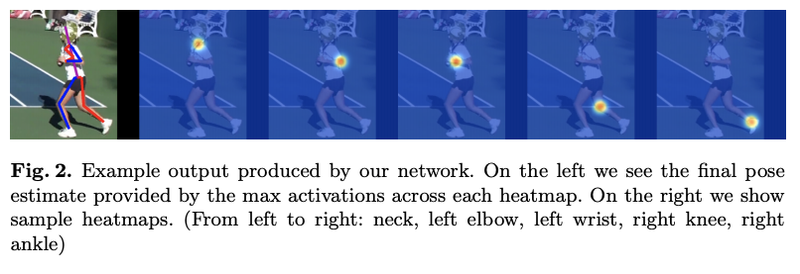

확률 분포로는 2차원 가우시안 분포를 사용합니다.  
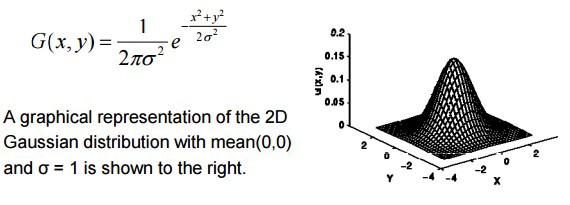

#### Q. 2차원 가우시안 분포의 확률 밀도 함수는 어떤 형태를 가지나요?
타원형의 확률 밀도 함수를 가지며, $\boldsymbol{\mu}$가 중심을, 공분산 행렬$\Sigma$ 이 타원의 형태와 방향을 결정

In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


지금까지 만든 함수들을 개별 함수로도 만들 수 있지만 객체 형태로 조합해 볼게요. 객체 형태로 만들면 선언부는 복잡해 보여도 훨씬 장점이 많습니다. 함수에서 객체의 메서드로 수정할 때는 self를 추가해야 하는 점을 잊지 마세요!

In [14]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


# 23-6. 모델을 학습해보자

### Hourglass 모델 만들기
---
이전 살펴봤던 hourglass 모델, 잘 기억하고 계신가요?

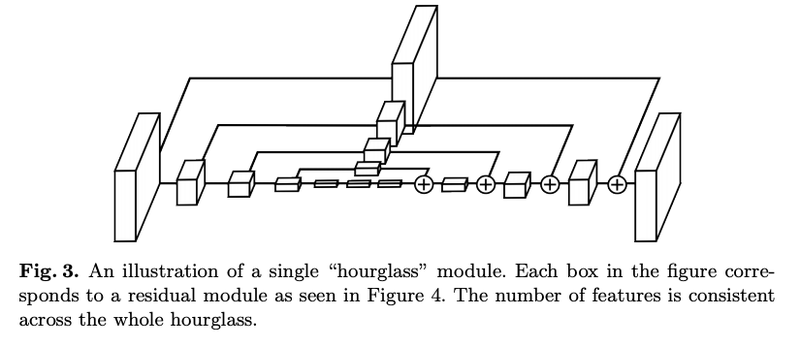

이렇게 생겼었죠! 직육면체 박스는 residual block 이었습니다. 하나씩 구현해 볼게요.

In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


### Q. residual block 의 2가지 타입을 간단하게 작성해주세요. (N사 면접기출)
Identity Block : 입력과 출력의 차원이 동일할 때 사용  
Convolutional Block  : 입력과 출력의 차원이 다를 때 사용(1x1 Convolution을 사용)

3x3-3x3 basic block, 1x1-3x3-1x1 bottleneck block

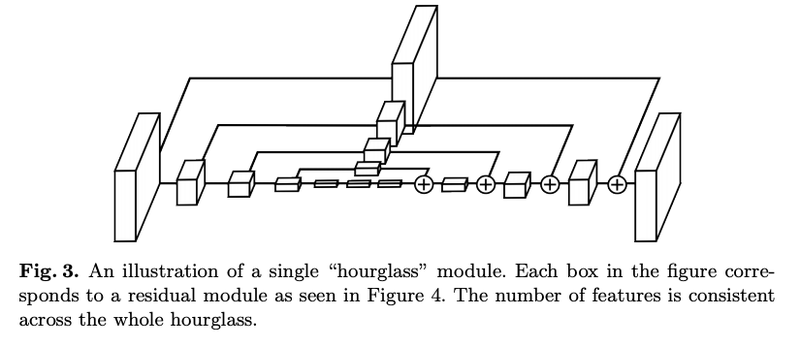  

다시 돌아와서 hourglass 모델을 잘 생각해 보면 마치 양파처럼 가장 바깥의 layer 를 제거하면 똑같은 구조가 나타나는 것을 알 수 있습니다. 이 점을 이용해서 간단하게 모델을 표현할 수 있는데요.

바로 재귀 함수를 이용하는 것이겠죠! 바깥부터 5개의 양파껍질(층)을 만들고 싶다면 order 를 이용해서 5,4...1 이 될 때까지 HourglassModule 을 반복하면 order 가 1이 되면 BottleneckBlock 으로 대체해 주면 아주 간결하게 만들 수 있습니다.

In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


intermediate output을 위한 linear layer  

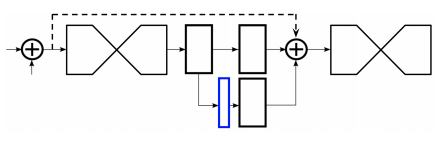  

여러 모듈을 쌓을수록 모델이 깊어지는 만큼 학습이 어려워, 저자들은 Intermediate supervision을 적용하였습니다.
도식에서 보이는 모듈 사이의 네트워크의 파란 박스는 모델 중간에 계산되는 히트맵 결과를 출력하는 convolution layer입니다. 이 히트맵과 ground truth의 차이를 intermediate loss (auxilary loss) 로 계산합니다. 이로써 stacked hourglass module은 보다 정교한 결과를 도출해냅니다.
Intermediate supervision의 효능이 더 궁금하다면, 다음의 포스트를 읽어보세요!
Stacked Hourglass Networks : pose estimation 논문  https://modulabs.co.kr/blog/stacked-hourglass-networks-pose-estimation

#### Stacked hourglass 모듈이 총 4개라면, 한 번의 학습에 몇 번의 loss가 계산될까요?
모듈이 총 4개라면, 3번의 intermediate loss와 최종 결과까지 총 4번의 loss가 계산됩니다.

In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


따라서 stacked 되는 hourglass 층 사이사이에 LinearLayer 를 삽입하고 중간 loss 를 계산해 줍니다.

지금까지 만든 hourglass 를 여러 층으로 쌓으면 stacked hourglass 가 됩니다.  

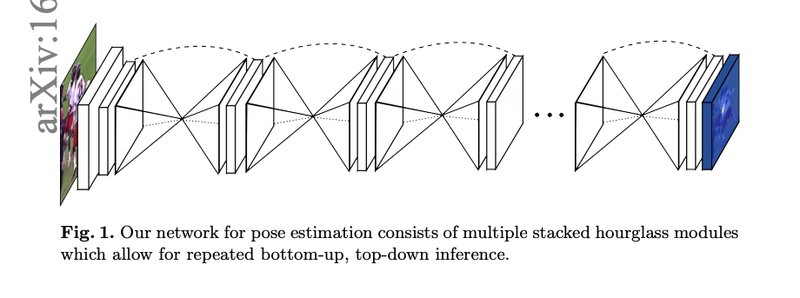  

In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


이제 StackedHourglassNetwork만 이용하면 모델을 쉽게 만들 수 있습니다.

# 23-7. 학습 엔진 만들기

### GPU가 여러 개인 환경
---
이제 모델 학습을 진행할 차례입니다.

그런데 학습을 할 수 있는 GPU가 여러 개이고 데이터를 병렬로 학습시키려면 어떻게 해야할까요? 여러 GPU를 사용하기 위해서는 약간의 코드를 추가해줘야 합니다. 학습 환경은 GPU가 하나이지만 나중에 기업 환경에서 여러 GPU를 사용할 수 있으니 살짝 공부해 봅시다.

- Distributed training with Keras https://www.tensorflow.org/tutorials/distribute/keras?hl=ko  

가장 핵심 키워드는 tf.distribute.MirroredStrategy입니다. 한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법인데요. 여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합합니다. 그런 후 모델의 가중치를 업데이트 하도록 하는 것이죠.

각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 strategy.reduce 함수가 담당합니다.

이번에도 각 함수를 별개로 만들지 않고 하나의 객체로 만들어 봅니다.

In [19]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


#### Q. tf.distribute.MirroredStrategy외에 Tensorflow의 GPU 분산 훈련을 위한 전략 메소드는 또 무엇이 있는지 알아볼까요?
MirroredStrategy : TensorFlow에서 다중 GPU 환경에서 모델을 훈련하기 위한 분산 전략  

TPUStrategy : 구글의 Tensor Processing Units(TPU)를 사용하여 모델을 훈련하기 위한 분산 전략  

MultiWorkerMirroredStrategy : 다중 워커(worker) 환경에서 모델을 훈련하기 위한 분산 전략  

ParameterServerStrategy : 다중 서버(server) 환경에서 모델을 훈련하기 위한 분산 전략  

CentralStorageStrategy : 중앙 저장소를 사용하여 모델을 훈련하기 위한 분산 전략  


이제 데이터셋을 만드는 함수를 작성합니다. TFRecord 파일이 여러개이므로 tf.data.Dataset.list_files를 통해 불러옵니다.

In [20]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


이제 데이터셋과 모델, 훈련용 객체를 조립만하면 되겠군요. 하나의 함수로 만들어 줄 텐데요. 주의할 점은 with strategy.scope():부분이 반드시 필요하다는 점이에요.

- Custom training with tf.distribute.Strategy https://www.tensorflow.org/tutorials/distribute/custom_training?hl=ko   

또 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다는 것도 중요해요.

In [21]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


이제 꽤 어려웠던 모든 준비가 끝났군요. 모델을 학습시킬 차례입니다. 학습에는 오랜 시간이 걸리기 때문에 여기서는 동작하는 코드만 확인해봅시다. (1 Epoch 학습에만 1 시간 가까이 소요됩니다.😮)
```python
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 2
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)
```

# 23-8. 둠칫둠칫 댄스타임

### 예측 엔진 만들기
이제 학습이 끝난 모델이 얼마나 잘 예측하는지 확인해 볼 시간입니다. 미리 학습된 모델을 불러옵시다.

In [22]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# model.load_weights(best_model_file)

학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정해 줍니다. 변수에 저장되는 것은 해당 부위를 나타내는 인덱스예요.

In [23]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨던 것이 기억 나시나요? 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap입니다. 그래서 이 heatmap으로부터 좌표를 추출해야해요. heatmap중에 최대값을 갖는 지점을 찾아내면 되겠네요. heatmap에서 최대값을 찾는 함수를 만들어 줍니다.

In [24]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구해줍니다.

In [25]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


이제 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수를 만들어 줍니다. 편리하게 사용할 수 있도록이요.

In [26]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


거의 다 온 것 같습니다. 이제 그림만 그려주면 완성될 것 같네요. 그림을 그릴 때는 두 가지 그림을 그려볼 겁니다. keypoint들과 뼈대입니다. keypoint들은 관절 역할을 하고 keypoint들을 연결시킨 것이 뼈대가 되겠네요.

두 가지 함수를 각각 작성해 줍니다.

In [27]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


자 이제 테스트 이미지를 이용해 모델의 성능을 확인해 봅시다.

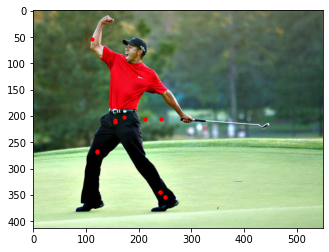

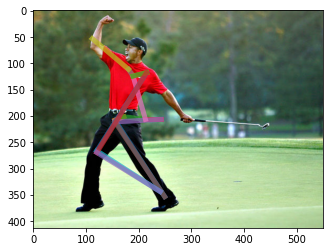

In [28]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)